# Purpose
The purpose of this notebook is to learn if the same consolidation of columns as found effective for v2 can be applied to the dataset `kaggle_uncleaned.parquet`.

# Summary


In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_parquet(
    "https://github.com/Immobilienrechner-Challenge/data/blob/main/kaggle_uncleaned.parquet?raw=true"
)


In [3]:
df.shape


(24556, 132)

In this dataset there are fewer columns than before. We expect there to be no price column given the task.

In [4]:
# Read v2 data
df_v2 = pd.read_parquet(
    "https://github.com/Immobilienrechner-Challenge/data/blob/main/immo_data_202208_v2.parquet?raw=true"
)


In [5]:
# Show what columns are not in the new data but are in v2
df_v2.columns.difference(df.columns)


Index(['price', 'price_cleaned', 'price_s', 'type'], dtype='object')

This shows that not only the price columns are missing but also the column `type`, which we don't need for our processing anyway. 

In [6]:
df_cleaned = pd.DataFrame()


# Living Space
In v2 of the data, the information in `Space extracted` and `Living_area_unified` was equal but does this still hold true?

In [7]:
# Select relevant columns
cols_living_space = ["Space extracted", "Living_area_unified"]
df_living_space = df[cols_living_space]


## NA Heatmap

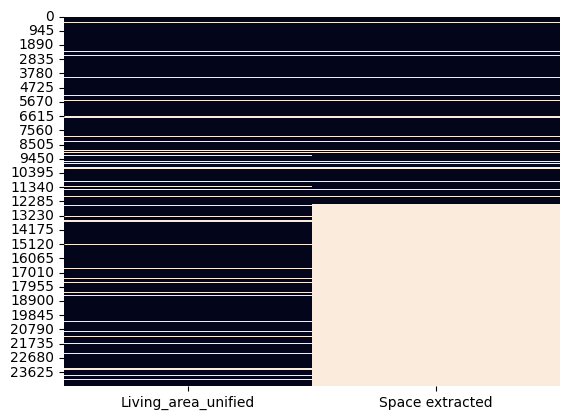

In [8]:
# Sort columns by number of non-null values
df_living_space = df_living_space.reindex(
    df_living_space.count().sort_values(ascending=False).index, axis=1
)

# Create isna heatmap
sns.heatmap(df_living_space.isna(), cbar=False)
plt.show()


Apparently not. `Living_area_unified` clearly contains more information than `Space extracted` but `Space extracted` can fill some missing values in `Living_area_unified`.

In [9]:
# Fill na values in living_area_unified with values from Space extracted
df_living_space["living_space"] = df_living_space["Living_area_unified"].fillna(
    df_living_space["Space extracted"]
)


In [10]:
df_living_space["living_space"].describe()


count    22742.000000
mean       154.821871
std        121.357184
min          1.000000
25%         97.000000
50%        129.000000
75%        179.750000
max       4362.000000
Name: living_space, dtype: float64

# Rooms

Since we only found one reliable way to extract the rooms we'll also use it here and see how much data we can gather.

In [11]:
# Extract rooms as in v2
df_cleaned["rooms"] = (
    df["details_structured"].str.extract("(\d+\.?\d?) rooms").astype(float)
)
df_cleaned["rooms"] = df["rooms"].fillna(df["No. of rooms:"])


In [12]:
df_cleaned["rooms"] = df_cleaned["rooms"].replace("", np.nan)


In [13]:
df_cleaned["rooms"].count()


23557

# Plot Area
Since we only found one reliable way to extract the plot area we'll also use it here and see how much data we can gather.

In [14]:
# Extract plot area as in v2
df_cleaned["plot_area"] = (
    df["Plot_area_merged"]
    .fillna(df["detail_responsive#surface_property"])
    .fillna(df["Land area:"])
)


In [15]:
df_cleaned["plot_area"].count()


9484

# Floor Space
Since we only found one reliable way to extract the floor space we'll also use it here and see how much data we can gather.

In [16]:
# Extract floor space as in v2
df_cleaned["floor_space"] = (
    df["Floor_space_merged"]
    .fillna(df["detail_responsive#surface_usable"])
    .fillna(df["Floor space:"])
)


# Floor
Since we only found one reliable way to extract the floor we'll also use it here and see how much data we can gather.

In [17]:
# Extract floor as in v2
df_cleaned["floor"] = (
    df["Floor_merged"].fillna(df["detail_responsive#floor"]).fillna(df["Floor"])
)


# Avaliability
Since we only found one reliable way to extract the availability we'll also use it here and see how much data we can gather.

In [18]:
# Extract avaliability as in v2
df_cleaned["availability"] = df["Availability_merged"].fillna(
    df["detail_responsive#available_from"]
)


# Zip code
The following code explores if the methods used so far to extract the zip code from the available data still yield a complete dataset.

In [19]:
# Extract zip code as in v2
df_cleaned["zip_code"] = df["address"].str.extract(r"(\d{4}) [A-ZÀ-Ÿ]")
df_cleaned["zip_address_s"] = df["address_s"].str.extract("(\d{4}) [A-ZÀ-Ÿ]")
df_cleaned["zip_code"] = df_cleaned["zip_code"].fillna(df_cleaned["zip_address_s"])


In [20]:
df_cleaned["zip_code"].count() == df_cleaned.shape[0]


False

It looks like there are missing values.

In [21]:
df.iloc[df_cleaned[df_cleaned["zip_code"].isna()].index]["address"]


22022    6862 rancate
Name: address, dtype: object

There is a municipality name written in lower case, which was not caught by the regex. Adjusting it accordingly should yield a complete dataset.

In [22]:
# Extract zip code with adjustment for lower case letters
df_cleaned["zip_code"] = df["address"].str.extract(r"(\d{4}) [A-ZÀ-Ÿa-z]")
df_cleaned["zip_address_s"] = df["address_s"].str.extract("(\d{4}) [A-ZÀ-Ÿa-z]")
df_cleaned["zip_code"] = df_cleaned["zip_code"].fillna(df_cleaned["zip_address_s"])


In [23]:
df_cleaned["zip_code"].count() == df_cleaned.shape[0]


True

# Municipality
The following code explores if the methods used so far to extract the municipality from the available data still yield a complete dataset.

In [24]:
# Extract municipality as in v2
df_cleaned["municipality"] = df["address"].str.extract(r"\d{4} (.+?),")
df_cleaned["municipality_address_s"] = df["address_s"].str.extract(r"\d{4} (.+)$")
df_cleaned["municipality"] = df_cleaned["municipality"].fillna(
    df_cleaned["municipality_address_s"]
)

df_cleaned.drop("municipality_address_s", axis=1, inplace=True)


In [25]:
df_cleaned["municipality"].count() == df_cleaned.shape[0]


False

In [26]:
# Show where na
df.iloc[df_cleaned[df_cleaned["municipality"].isna()].index]["address"]


10423    6958 Capriasca
Name: address, dtype: object

In [27]:
# Replace na with Capriasca
df_cleaned["municipality"] = df_cleaned["municipality"].fillna("Capriasca")


In [28]:
df_cleaned["municipality"].count() == df_cleaned.shape[0]


True

# Canton
Like before we can read the canton from the excel file.

In [29]:
df_xlsx_plz = pd.read_excel(
    "https://github.com/Immobilienrechner-Challenge/data/raw/main/plz.xlsx",
    sheet_name="Blatt1",
)
df_xlsx_plz.drop(
    ["Kanton", "Canton", "Cantone", "Land", "Pays", "Paese"], axis=1, inplace=True
)
df_xlsx_plz.rename(
    columns={
        df_xlsx_plz.columns[0]: "plz",
        df_xlsx_plz.columns[1]: "municipality",
        df_xlsx_plz.columns[2]: "canton",
    },
    inplace=True,
)
df_xlsx_plz.drop_duplicates(subset=["plz"], inplace=True)


In [30]:
# Read canton as in v2
df_cleaned["canton"] = (
    df_cleaned["zip_code"]
    .astype(int)
    .map(df_xlsx_plz.set_index("plz")["canton"])
    .copy()
)


In [31]:
# Show missing values
df_cleaned[df_cleaned["canton"].isna()]


,rooms,plot_area,floor_space,floor,availability,zip_code,zip_address_s,municipality,municipality_address_s,canton
7992,5.0,None,None,Ground floor,On request,8371,NaN,Busswil TG,NaN,NaN
7994,5.0,None,None,1. floor,On request,8371,NaN,Busswil TG,NaN,NaN
18252,5.5rm,977 m2,46 m2,None,None,2737,2737,Bévilard,Bévilard,NaN
18253,5.5rm,977 m2,46 m2,None,None,2737,2737,Bévilard,Bévilard,NaN
18597,8.5rm,1430 m2,77 m2,None,None,3217,3217,Mühlethurnen,Mühlethurnen,NaN
18598,7.5rm,1430 m2,77 m2,None,None,3217,3217,Mühlethurnen,Mühlethurnen,NaN
18733,6.5rm,202 m2,None,GF,None,3364,3364,Seeberg,Seeberg,NaN
21304,2.5rm,None,50 m2,1,None,6511,6511,Cadenazzo,Cadenazzo,NaN
21305,4.5rm,None,None,None,None,6511,6511,Cadenazzo,Cadenazzo,NaN
21306,3.5rm,None,None,GF,None,6511,6511,Cadenazzo,Cadenazzo,NaN


By manual inspection we found the correct zip codes for these rows:

In [32]:
# Clean up zip_code typos
df_cleaned.loc[df_cleaned["zip_code"] == "2737", "zip_code"] = "2735"
df_cleaned.loc[df_cleaned["zip_code"] == "3217", "zip_code"] = "3127"
df_cleaned.loc[df_cleaned["zip_code"] == "3364", "zip_code"] = "3365"
df_cleaned.loc[df_cleaned["zip_code"] == "6511", "zip_code"] = "6593"
df_cleaned.loc[df_cleaned["zip_code"] == "8371", "zip_code"] = "8370"


In [33]:
df_cleaned["canton"] = (
    df_cleaned["zip_code"]
    .astype(int)
    .map(df_xlsx_plz.set_index("plz")["canton"])
    .copy()
)


In [34]:
df_cleaned[df_cleaned["canton"].isna()]


,rooms,plot_area,floor_space,floor,availability,zip_code,zip_address_s,municipality,municipality_address_s,canton


And with that we have a complete dataset regarding the zip_code, municipality and canton.

# Street
We process the street including its number as before, taking it from `address` as we found this to be the most reliable solution.

In [35]:
# Extract street as in v2
df_cleaned["street"] = df["address"].str.extract(r"(.+), \d{4}")
df_cleaned.loc[df_cleaned["street"] == "-", "street"] = np.nan
df_cleaned.loc[df_cleaned["street"] == "à", "street"] = np.nan


In [36]:
df_cleaned["street"].count()


11579

# Street number

In [37]:
# Extract street number as in v2
df_cleaned["street_nr"] = df_cleaned["street"].str.extract(r"^.+ (\d.+)")

# Separate street name from street number
df_cleaned["street"] = df_cleaned["street"].str.extract(r"^(.+?) \d")
df_cleaned["street"] = df_cleaned["street"].str.rstrip()


In [38]:
df_cleaned["street_nr"].count()


5423